In [1]:
import torch
from torch import nn
import pandas as pd
from geoclip import LocationEncoder
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import umap
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:

# Define the VAE model
class SAVAE(nn.Module):
    def __init__(self):
        super(SAVAE, self).__init__()
        # Define the concatenation part
        self.fc11 = nn.Linear(12, 64)
        self.fc12 = nn.Linear(512, 64)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        # Define the second fully connected layer for mu
        self.fc21 = nn.Linear(128, 16)
        # Define the third fully connected layer for logvar
        self.fc22 = nn.Linear(128, 16)
        # Define the fourth fully connected layer for decoding
        self.fc3 = nn.Linear(16, 12)
        # Define the classifier layer
        self.classifier = nn.Linear(16, 3)
        self.LocEncoder = LocationEncoder()

    # Define the encoder part of VAE
    def encode(self, x_concat):
        h1 = self.LeakyReLU(x_concat)
        return self.fc21(h1), self.fc22(h1)


    def reparameterize(self, mu, logvar):
            # std = torch.exp(0.5*logvar)
            # eps = torch.randn_like(std)
            return mu

    # Define the decoder part of VAE
    def decode(self, z):
        h3=self.fc3(z)
        return torch.sigmoid(h3)

    def forward(self,x):
        x1=x[:,2:]
        x2=x[:,:2]
        
        loc_embed=self.LocEncoder(x2)
        x_concat=torch.cat((self.fc12(loc_embed), self.fc11(x1)), dim=1)
        mu, logvar = self.encode(x_concat.view(-1, x_concat.shape[1]))
        z = self.reparameterize(mu, logvar)
        # dimension of z is 16
        # return the reconstructed x, the classifier output, mu and logvar
        return self.decode(z), self.classifier(z), mu, logvar, z

# Define the loss function
def loss_function(recon_x, x1, mu, logvar, y, y_pred, class_weights):

    # Calculate the Mean Squared Error loss
    MSE = F.mse_loss(recon_x, x1, reduction='sum')
    # Calculate the KL Divergence
    KLD = beta_value*(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    # Calculate the Cross Entropy loss
    CE = F.cross_entropy(y_pred, y, weight=class_weights)
    # The total loss is the sum of MSE, KLD, and CE
    return MSE, KLD, CE

In [3]:
df_data_encoded_county=pd.read_excel("./v2_data/v2_data_coordinated_encoded_final_county.xlsx")

In [4]:
df_data_encoded_county.reset_index(drop=True, inplace=True)
data_X=df_data_encoded_county.drop(columns=['outcome','county'])
object = MinMaxScaler()
arr_scaled=object.fit_transform(data_X.drop(columns=['lat','lon']))
df_coord = data_X[['lat', 'lon']]
df_scaled=pd.DataFrame(arr_scaled, columns=data_X.drop(columns=['lat','lon']).columns)
df_scaled_coord = pd.concat([df_coord, df_scaled], axis=1)

# convert object to float
df_scaled_coord = df_scaled_coord.astype(float)
df_scaled_coord_tensor=torch.tensor(df_scaled_coord.values).float()

# Load the saved state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=SAVAE().to(device)

model.load_state_dict(torch.load('v2_best_savae_model_dict.pth'))
model.eval()
df_scaled_coord_tensor=df_scaled_coord_tensor.to(device)
__, __, __, __, z = model(df_scaled_coord_tensor)

In [5]:
z.shape

torch.Size([5385, 16])

In [6]:
z_numpy = z.detach().cpu().numpy()
# create the embedding table with county column
df_z_county = pd.concat([pd.DataFrame(z_numpy),df_data_encoded_county[['county', 'outcome']]],axis=1)

In [7]:
# select 10 counties with the most examples
selected_counties=df_z_county['county'].value_counts().nlargest(10).index.to_list()
selected_top_counties= df_z_county[df_z_county['county'].isin(selected_counties)]
# sample 10 examples from each county
# np.random.seed(42)
counties_sampled=selected_top_counties.groupby('county').apply(lambda x: x.sample(10)).reset_index(drop=True)
counties_sampled.set_index('county', inplace=True)

/tmp/ipykernel_1664300/974452769.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counties_sampled=selected_top_counties.groupby('county').apply(lambda x: x.sample(10)).reset_index(drop=True)


In [8]:
# Initialize a UMAP object
reducer = umap.UMAP()
embedding = reducer.fit_transform(counties_sampled.iloc[:,:-1])
df_umap=pd.DataFrame(embedding,columns=['umap1','umap2'])
df_umap["county"]=counties_sampled.index.to_list()
df_umap["outcome"]=counties_sampled['outcome'].values
# df_umap.to_csv('./v2_output/v4_umap.csv',index=False)

In [9]:
zipfile = "./v2_data/Counties_Georgia.zip"
county_polygon = gpd.read_file(zipfile)

In [10]:
zipfile_state = "./v2_data/Georgia_State_Boundary.zip"
state_polygon = gpd.read_file(zipfile_state)

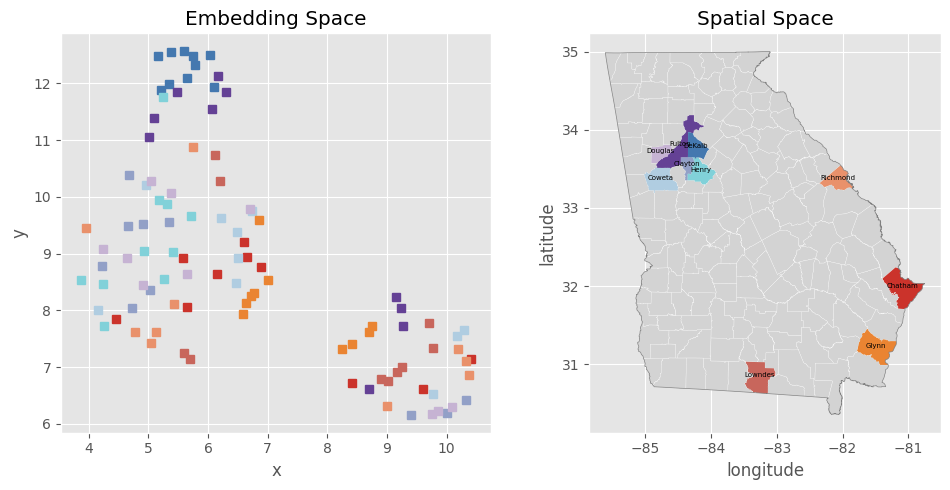

In [12]:

import warnings
warnings.filterwarnings('ignore')
df_umap_4=pd.read_csv('./v2_output/v2_umap4.csv')
df_umap_3=pd.read_csv('./v2_output/v2_umap3.csv')
df_umap_2=pd.read_csv('./v2_output/v2_umap2.csv')

# color_map = dict(zip(df_umap['county'], sns.color_palette("Spectral", len(df_umap))))
color_map= dict({'Chatham':'#CB332B', 'Richmond':'#E9916B','Glynn':'#EA8432','Lowndes':'#C8665C',
                 'Clayton':'#92A0C7', 'Coweta':"#B0CDE1", 'DeKalb':"#4478AF", 'Douglas':"#C6B3D3", 'Fulton':"#644195",'Henry':"#81D1D9"})
# suppress warning
fig, axs = plt.subplots(1, 2, figsize=(10,5))
plt.style.use('ggplot')
# Plot the centroids
for i, row in df_umap_4.iterrows():
    axs[0].plot(row['umap2'], row['umap1'], marker='s', color=color_map[row['county']])
axs[0].set_title('Embedding Space')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Assuming color_map is a dictionary mapping county names to colors
county_polygon.plot(ax=axs[1], color='lightgray', edgecolor='white', linewidth=0.2)
county_polygon_sub=county_polygon[county_polygon['NAME10'].isin(selected_counties)]
county_polygon_sub['color']=county_polygon_sub['NAME10'].map(color_map)
county_polygon_sub.plot(ax=axs[1], color=county_polygon_sub['color'])
county_polygon_sub.apply(lambda x: axs[1].annotate(text=x['NAME10'], xy=x.geometry.centroid.coords[0], ha='center', size=5), axis=1)
state_polygon.plot(ax=axs[1], color='none', edgecolor='gray', linewidth=0.5)
axs[1].set_title('Spatial Space')
axs[1].set_xlabel('longitude')
axs[1].set_ylabel('latitude')
plt.style.use('ggplot') 
plt.tight_layout()
plt.savefig('embedding_plot_4.svg', dpi=350)

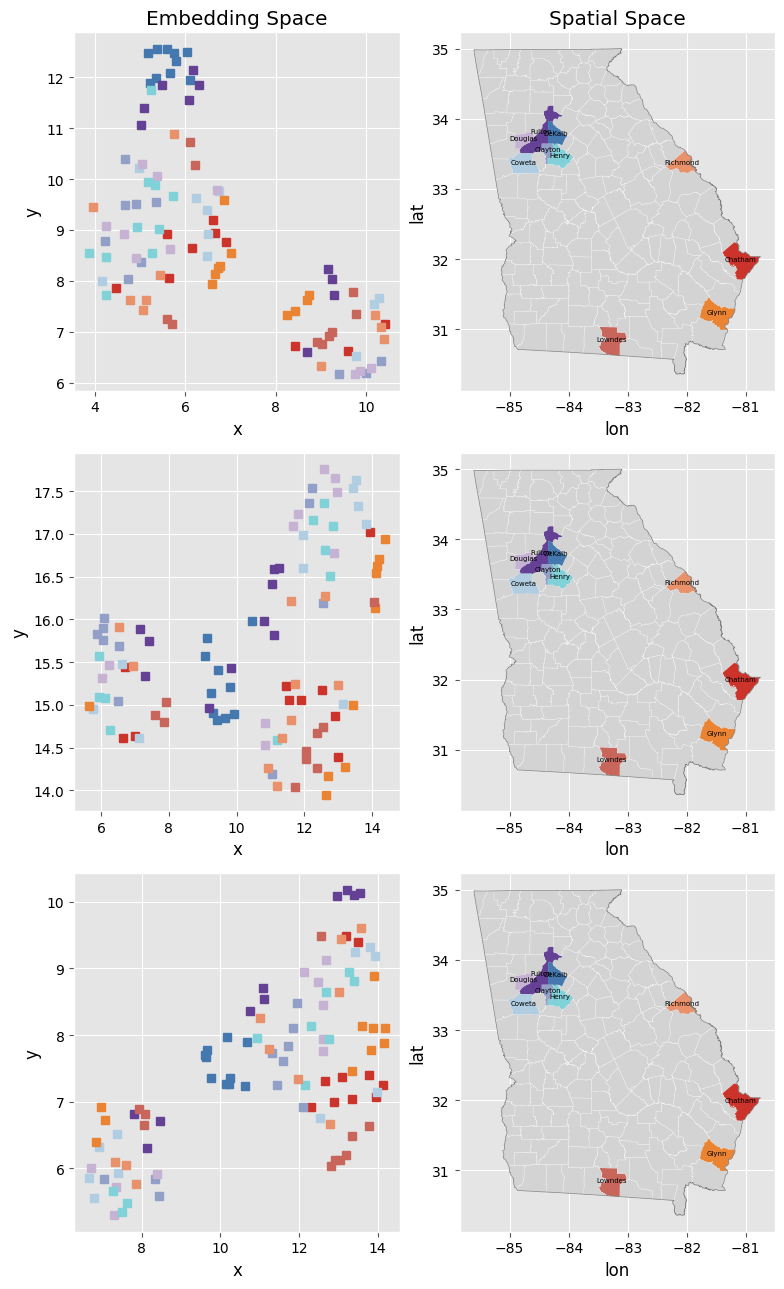

In [44]:
fig, axs = plt.subplots(3, 2, figsize=(8,13))
plt.style.use('ggplot')

# DataFrames to loop over
dfs = [df_umap_4,df_umap_2, df_umap_3]

# Plot the centroids
for i, df in enumerate(dfs):
    for j, row in df.iterrows():
        if i==0:
            axs[i, 0].plot(row['umap2'], row['umap1'], marker='s', color=color_map[row['county']])
        else:
            axs[i, 0].plot(row['umap1'], row['umap2'], marker='s', color=color_map[row['county']])
            
    if i==0:
        axs[i, 0].set_title('Embedding Space', color='black')
        axs[i, 0].set_xlabel('x', color='black')
        axs[i, 0].set_ylabel('y', color='black')
    else:
        axs[i, 0].set_xlabel('x', color='black')
        axs[i, 0].set_ylabel('y', color='black')
    axs[i, 0].tick_params(axis='both', labelcolor='black')

    # Assuming color_map is a dictionary mapping county names to colors
    county_polygon.plot(ax=axs[i, 1], color='lightgray', edgecolor='white', linewidth=0.2)
    county_polygon_sub=county_polygon[county_polygon['NAME10'].isin(selected_counties)]
    county_polygon_sub['color']=county_polygon_sub['NAME10'].map(color_map)
    county_polygon_sub.plot(ax=axs[i, 1], color=county_polygon_sub['color'])
    state_polygon.plot(ax=axs[i, 1], color='none', edgecolor='gray', linewidth=0.5)
    
    county_polygon_sub.apply(lambda x: axs[i, 1].annotate(text=x['NAME10'], xy=x.geometry.centroid.coords[0], ha='center', size=5), axis=1)
    if i==0:
        axs[i, 1].set_title('Spatial Space', color='black')
        axs[i, 1].set_xlabel('lon', color='black')
        axs[i, 1].set_ylabel('lat', color='black')
        
    else:
        axs[i, 1].set_xlabel('lon', color='black')
        axs[i, 1].set_ylabel('lat', color='black')
    axs[i, 1].tick_params(axis='both', labelcolor='black')

plt.tight_layout()
plt.savefig('embeddings_plots.png', dpi=350)